**OBJECTIVE:** Recreate pictures and tables in the manuscript

In [2]:
import numpy as np
import pandas as pd
import igraph as ig

from modSAR.network_algorithms import ModSAR
from modSAR.dataset import QSARDatasetIO
from scripts.validation import DataSplit

from sklearn.externals import joblib

from plotnine import *
%matplotlib inline

datasets = ['NYPR1', 'NYPR2', 'CHRM3', 'hDHFR', 'rDHFR']

qsar_datasets = \
{dataset_name:
    QSARDatasetIO.load(dataset_name=dataset_name, 
                       filepath='/mnt/data/%s.xlsx' % dataset_name, 
                       calculate_similarity=False)
 for dataset_name in datasets
}

# Data Input and Preparation

In [83]:
# Read spreadsheets containing test results
dataset_results = []
for dataset_name in datasets:
    for i in range(1, 5+1):
        dataset_results.append(pd.read_excel('/mnt/data/results/%s/results_%s_split%02d_alg_modsar.xlsx' % 
                                             (dataset_name, dataset_name, i)))
dataset_results = pd.concat(dataset_results)
dataset_results['dataset'] = pd.Categorical(dataset_results['dataset'], categories=qsar_datasets)

In [138]:
data_splits = {
    dataset_name: DataSplit(qsar_dataset, filename='/mnt/data/%s_splits.xlsx' % dataset_name)
    for dataset_name, qsar_dataset in qsar_datasets.items()}

In [5]:
# Read best regression models generated by the algorithm for each data split
best_models = \
{dataset_name :
    [joblib.load('/mnt/data/results/%s/%s_split%02d_alg_modsar.joblib' % (dataset_name, dataset_name, i)) 
     for i in range(1, 5+1)]
 for dataset_name in datasets
}

In [167]:
rf_models = \
{dataset_name :
    [joblib.load('/mnt/data/results/%s/%s_split%02d_alg_rf.joblib' % (dataset_name, dataset_name, i)) 
     for i in range(1, 5+1)]
 for dataset_name in datasets
}

# Tables

## Table 2 - Network characteristics

Statistics of networks created in every test

In [44]:
def get_network_stats(name, i, g):
    modules = pd.Series(g.vs['louvain']).value_counts()
    return pd.DataFrame({'dataset' : name, 
                         'data_split': i + 1,
                         'nodes': len(g.vs),
                         'density': g.density(),
                         'threshold': g['threshold'],
                         'ACC': g['globalClusteringCoefficient'],
                         'modularity': g.modularity(pd.Categorical(g.vs['louvain']).codes),
                         'number_main_modules': len(modules[modules != 1]),
                         'number_singletons': len(modules[modules == 1]),
                         'average_degree': np.mean(g.degree()),
                         'average_path_length': g.average_path_length(),
                         'degree_assortativity': g.assortativity_degree()},
                        index=[0])

network_stats = []

for dataset_name in datasets:
    for i in range(5):
        network_stats.append(get_network_stats(dataset_name, i, best_models[dataset_name][i].instance_graph))

network_stats = pd.concat(network_stats)
network_stats['dataset'] = pd.Categorical(network_stats['dataset'], categories=qsar_datasets)

### Alternative 1: Ranges

In [66]:
int_cols = ['nodes', 'number_main_modules', 'number_singletons']

def value_ranges(data):
    stats = data.describe()
    features = stats.columns.tolist()
    return pd.Series({feat: '[%.2f - %.2f]' % (stats[feat].loc['min'], stats[feat].loc['max']) if feat not in int_cols 
                      else '[%d - %d]' % (stats[feat].loc['min'], stats[feat].loc['max']) for feat in features})

network_stats_range = network_stats.drop(columns=['data_split']).groupby(['dataset']).apply(value_ranges)
network_stats_range

,nodes,density,threshold,ACC,modularity,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
dataset,,,,,,,,,,
NYPR1,[247 - 248],[0.05 - 0.07],[0.24 - 0.28],[0.63 - 0.65],[0.77 - 0.81],[11 - 20],[23 - 57],[12.65 - 16.15],[1.64 - 4.95],[0.58 - 0.79]
NYPR2,[256 - 257],[0.11 - 0.14],[0.25 - 0.28],[0.68 - 0.73],[0.57 - 0.63],[7 - 14],[17 - 40],[29.41 - 35.30],[2.74 - 2.95],[0.78 - 0.91]
CHRM3,[434 - 436],[0.08 - 0.10],[0.30 - 0.31],[0.72 - 0.75],[0.54 - 0.62],[14 - 18],[20 - 28],[36.17 - 43.09],[3.52 - 4.19],[0.64 - 0.69]
hDHFR,[377 - 379],[0.10 - 0.10],[0.34 - 0.35],[0.73 - 0.76],[0.63 - 0.66],[11 - 12],[4 - 7],[36.52 - 39.22],[2.75 - 2.85],[0.46 - 0.53]
rDHFR,[596 - 597],[0.06 - 0.08],[0.37 - 0.40],[0.64 - 0.65],[0.63 - 0.69],[7 - 11],[1 - 3],[37.37 - 48.79],[2.70 - 3.06],[0.47 - 0.51]


In [68]:
# print(network_stats_range.to_latex())

### Alternative 2: Mean $\pm$ STD

In [59]:
def mean_std(data):
    stats = data.describe()
    features = stats.columns.tolist()
    return pd.Series({feat: '%.2f (\pm %.2f)$' % (stats[feat].loc['mean'], stats[feat].loc['std']) 
                      for feat in features})

network_stats_df = network_stats.drop(columns=['data_split']).groupby(['dataset']).apply(mean_std)
network_stats_df

,nodes,density,threshold,ACC,modularity,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
dataset,,,,,,,,,,
NYPR1,247.40 (\pm 0.55)$,0.06 (\pm 0.01)$,0.25 (\pm 0.02)$,0.64 (\pm 0.01)$,0.78 (\pm 0.02)$,13.60 (\pm 3.78)$,32.00 (\pm 14.28)$,15.16 (\pm 1.45)$,3.95 (\pm 1.32)$,0.67 (\pm 0.08)$
NYPR2,256.60 (\pm 0.55)$,0.13 (\pm 0.01)$,0.26 (\pm 0.01)$,0.69 (\pm 0.02)$,0.60 (\pm 0.03)$,10.40 (\pm 2.70)$,25.80 (\pm 9.83)$,31.97 (\pm 2.18)$,2.81 (\pm 0.09)$,0.83 (\pm 0.06)$
CHRM3,434.80 (\pm 0.84)$,0.09 (\pm 0.01)$,0.31 (\pm 0.00)$,0.73 (\pm 0.01)$,0.58 (\pm 0.04)$,16.60 (\pm 1.67)$,23.80 (\pm 3.03)$,40.18 (\pm 2.71)$,3.84 (\pm 0.30)$,0.67 (\pm 0.02)$
hDHFR,377.80 (\pm 0.84)$,0.10 (\pm 0.00)$,0.35 (\pm 0.01)$,0.75 (\pm 0.01)$,0.65 (\pm 0.01)$,11.40 (\pm 0.55)$,5.60 (\pm 1.34)$,37.55 (\pm 1.12)$,2.81 (\pm 0.05)$,0.49 (\pm 0.03)$
rDHFR,596.80 (\pm 0.45)$,0.08 (\pm 0.01)$,0.38 (\pm 0.01)$,0.64 (\pm 0.00)$,0.65 (\pm 0.02)$,8.40 (\pm 1.67)$,2.20 (\pm 0.84)$,44.80 (\pm 4.40)$,2.79 (\pm 0.15)$,0.50 (\pm 0.01)$


## Table 3 - Performance in external set

## Table S1 - Cross Validation Results

In [81]:
dataset_results.head()

,splitStrategy,splitNumber,dataset,datasetVersion,fold,algorithm,algorithm_version,internal,no_modules,no_classes,threshold,train_mae,test_mae,train_rmse,test_rmse,fit_time,beta,lambda
0,1,1,NYPR1,default,1,modSAR,v0.1,True,40,60,0.24,0.105930,0.603444,0.356704,0.925563,51.595313,0.03,0.005
1,1,1,NYPR1,default,1,modSAR,v0.1,True,40,65,0.24,0.364761,0.794514,0.681562,1.160931,21.082392,0.03,0.050
2,1,1,NYPR1,default,1,modSAR,v0.1,True,40,49,0.24,0.550385,0.651250,0.909222,0.987716,8.814755,0.03,0.100
3,1,1,NYPR1,default,2,modSAR,v0.1,True,39,70,0.24,0.119399,0.862748,0.354709,1.399845,67.931351,0.03,0.005
4,1,1,NYPR1,default,2,modSAR,v0.1,True,39,74,0.24,0.326296,0.595404,0.601451,0.939482,59.158343,0.03,0.050


In [132]:
def internal_training_results(data, cols=['train_mae']):
    return pd.Series(
        {feat: '$%.2f (\pm %.2f)$' % (np.mean(data[feat]), np.std(data[feat])) 
                      for feat in cols}
    )

### Internal Training - MAE

In [133]:
training_df = \
    dataset_results.query('internal == True').groupby(['dataset', 'splitNumber']).apply(internal_training_results)
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,train_mae,train_mae,train_mae,train_mae,train_mae
splitNumber,,,,,
1,$0.33 (\pm 0.18)$,$0.36 (\pm 0.17)$,$0.46 (\pm 0.12)$,$0.58 (\pm 0.18)$,$0.52 (\pm 0.14)$
2,$0.30 (\pm 0.17)$,$0.35 (\pm 0.15)$,$0.49 (\pm 0.13)$,$0.59 (\pm 0.20)$,$0.49 (\pm 0.14)$
3,$0.21 (\pm 0.11)$,$0.34 (\pm 0.16)$,$0.47 (\pm 0.12)$,$0.60 (\pm 0.20)$,$0.51 (\pm 0.14)$
4,$0.31 (\pm 0.16)$,$0.34 (\pm 0.15)$,$0.50 (\pm 0.14)$,$0.61 (\pm 0.17)$,$0.50 (\pm 0.13)$
5,$0.31 (\pm 0.16)$,$0.30 (\pm 0.13)$,$0.48 (\pm 0.13)$,$0.60 (\pm 0.19)$,$0.51 (\pm 0.14)$


In [128]:
# print(training_df.to_latex())

### Internal Validation - MAE

In [130]:
training_df = \
    dataset_results.query('internal == True').groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: internal_training_results(x, cols=['test_mae']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,test_mae,test_mae,test_mae,test_mae,test_mae
splitNumber,,,,,
1,$0.76 (\pm 0.20)$,$0.70 (\pm 0.20)$,$0.76 (\pm 0.14)$,$0.79 (\pm 0.12)$,$0.68 (\pm 0.09)$
2,$0.72 (\pm 0.19)$,$0.66 (\pm 0.18)$,$0.80 (\pm 0.16)$,$0.82 (\pm 0.10)$,$0.66 (\pm 0.09)$
3,$0.73 (\pm 0.17)$,$0.61 (\pm 0.12)$,$0.74 (\pm 0.16)$,$0.84 (\pm 0.11)$,$0.68 (\pm 0.10)$
4,$0.75 (\pm 0.21)$,$0.63 (\pm 0.12)$,$0.79 (\pm 0.13)$,$0.85 (\pm 0.10)$,$0.67 (\pm 0.10)$
5,$0.71 (\pm 0.20)$,$0.62 (\pm 0.12)$,$0.80 (\pm 0.22)$,$0.84 (\pm 0.12)$,$0.66 (\pm 0.09)$


### Internal Training - RMSE

In [134]:
training_df = \
    dataset_results.query('internal == True').groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: internal_training_results(x, cols=['train_rmse']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,train_rmse,train_rmse,train_rmse,train_rmse,train_rmse
splitNumber,,,,,
1,$0.62 (\pm 0.25)$,$0.57 (\pm 0.20)$,$0.73 (\pm 0.10)$,$0.82 (\pm 0.18)$,$0.74 (\pm 0.14)$
2,$0.57 (\pm 0.27)$,$0.56 (\pm 0.17)$,$0.76 (\pm 0.12)$,$0.84 (\pm 0.19)$,$0.72 (\pm 0.15)$
3,$0.47 (\pm 0.20)$,$0.53 (\pm 0.18)$,$0.74 (\pm 0.11)$,$0.85 (\pm 0.19)$,$0.74 (\pm 0.14)$
4,$0.59 (\pm 0.23)$,$0.55 (\pm 0.18)$,$0.77 (\pm 0.13)$,$0.87 (\pm 0.16)$,$0.73 (\pm 0.14)$
5,$0.58 (\pm 0.23)$,$0.49 (\pm 0.15)$,$0.75 (\pm 0.12)$,$0.86 (\pm 0.19)$,$0.74 (\pm 0.14)$


In [135]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &         train\_rmse &         train\_rmse &         train\_rmse &         train\_rmse &         train\_rmse \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$0.62 (\textbackslash pm 0.25)\$ &  \$0.57 (\textbackslash pm 0.20)\$ &  \$0.73 (\textbackslash pm 0.10)\$ &  \$0.82 (\textbackslash pm 0.18)\$ &  \$0.74 (\textbackslash pm 0.14)\$ \\
2           &  \$0.57 (\textbackslash pm 0.27)\$ &  \$0.56 (\textbackslash pm 0.17)\$ &  \$0.76 (\textbackslash pm 0.12)\$ &  \$0.84 (\textbackslash pm 0.19)\$ &  \$0.72 (\textbackslash pm 0.15)\$ \\
3           &  \$0.47 (\textbackslash pm 0.20)\$ &  \$0.53 (\textbackslash pm 0.18)\$ &  \$0.74 (\textbackslash pm 0.11)\$ &  \$0.85 (\textbackslash pm 0.19)\$ &  \$0.74 (\textbackslash pm 0.14)\$ \\


### Internal Validation - RMSE

In [136]:
training_df = \
    dataset_results.query('internal == True').groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: internal_training_results(x, cols=['test_rmse']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,test_rmse,test_rmse,test_rmse,test_rmse,test_rmse
splitNumber,,,,,
1,$1.12 (\pm 0.32)$,$1.01 (\pm 0.35)$,$1.03 (\pm 0.20)$,$1.03 (\pm 0.16)$,$0.91 (\pm 0.13)$
2,$1.07 (\pm 0.28)$,$0.97 (\pm 0.32)$,$1.07 (\pm 0.23)$,$1.06 (\pm 0.12)$,$0.89 (\pm 0.13)$
3,$1.04 (\pm 0.24)$,$0.85 (\pm 0.19)$,$1.00 (\pm 0.22)$,$1.09 (\pm 0.15)$,$0.91 (\pm 0.13)$
4,$1.12 (\pm 0.33)$,$0.87 (\pm 0.18)$,$1.07 (\pm 0.19)$,$1.09 (\pm 0.15)$,$0.91 (\pm 0.13)$
5,$1.07 (\pm 0.32)$,$0.90 (\pm 0.23)$,$1.08 (\pm 0.30)$,$1.08 (\pm 0.14)$,$0.89 (\pm 0.12)$


In [137]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &          test\_rmse &          test\_rmse &          test\_rmse &          test\_rmse &          test\_rmse \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$1.12 (\textbackslash pm 0.32)\$ &  \$1.01 (\textbackslash pm 0.35)\$ &  \$1.03 (\textbackslash pm 0.20)\$ &  \$1.03 (\textbackslash pm 0.16)\$ &  \$0.91 (\textbackslash pm 0.13)\$ \\
2           &  \$1.07 (\textbackslash pm 0.28)\$ &  \$0.97 (\textbackslash pm 0.32)\$ &  \$1.07 (\textbackslash pm 0.23)\$ &  \$1.06 (\textbackslash pm 0.12)\$ &  \$0.89 (\textbackslash pm 0.13)\$ \\
3           &  \$1.04 (\textbackslash pm 0.24)\$ &  \$0.85 (\textbackslash pm 0.19)\$ &  \$1.00 (\textbackslash pm 0.22)\$ &  \$1.09 (\textbackslash pm 0.15)\$ &  \$0.91 (\textbackslash pm 0.13)\$ \\


# Figures

## Error Distribution - Figures 5 to 7

In [171]:
def get_external_predictions(dataset_name, split_number, data_splits, models):
    alg = models[dataset_name][split_number - 1]
    data_split = data_splits[dataset_name]
    
    idx = data_split.get_id_external_samples(split_number)
    
    X = data_split.qsar_dataset.X.loc[idx]
    if alg.algorithm_name.lower() == 'modsar':
        X_smiles = data_split.qsar_dataset.X_smiles.loc[idx]
    y = data_split.get_external_Y(split_number)
    
    if alg.algorithm_name.lower() == 'modsar':
        y_pred = pd.Series(alg.predict(X, X_smiles))
    else:
        y_pred = pd.Series(alg.predict(X))
    y_pred.index = y.index.values
    y_pred.name = 'predicted'
    
    split_number = pd.DataFrame({'dataset': data_split.qsar_dataset.name, 
                                 'split_number': [1] * len(y_pred)}, index=y.index.values)
    
    return pd.concat([split_number, y, y_pred], axis=1)

In [144]:
# Calculate predictions for each sample in the external sets
external_predictions = []
for dataset_name in datasets:
    for i in range(1, 5+1):
        external_predictions.append(get_external_predictions(dataset_name, i, data_splits, best_models))
        

external_predictions = pd.concat(external_predictions)

Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the 

TypeError: cannot concatenate object of type "<class 'list'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [194]:
external_predictions['algorithm'] = 'modSAR'
rf_external_predictions['algorithm'] = 'Random Forest'

In [173]:
rf_external_predictions = []
for dataset_name in datasets:
    for i in range(1, 5+1):
        rf_external_predictions.append(get_external_predictions(dataset_name, i, data_splits, rf_models))
        
rf_external_predictions = pd.concat(rf_external_predictions)
rf_external_predictions['absolute_error'] =\
    abs(rf_external_predictions['pchembl_value'] - rf_external_predictions['predicted'])

In [210]:
external_predictions['absolute_error'] =\
    abs(external_predictions['pchembl_value'] - external_predictions['predicted'])

def get_absolute_error_stats(data):
    stats = data['absolute_error'].describe()
    return pd.Series({
        '25%': stats['25%'],
        '50%': stats['50%'],
        '75%': stats['75%'],
        'label': "median = %.2f\nQ1 = %.2f\nQ3 = %.2f" % (stats['50%'], stats['25%'], stats['75%'])})
    
external_abs_stats = external_predictions.groupby(['dataset', 'algorithm']).apply(get_absolute_error_stats)
rf_external_abs_stats = rf_external_predictions.groupby(['dataset', 'algorithm']).apply(get_absolute_error_stats)
external_abs_stats.reset_index()

,dataset,algorithm,25%,50%,75%,label
0,CHRM3,modSAR,0.208276,0.500000,0.977353,median = 0.50\nQ1 = 0.21\nQ3 = 0.98
1,NYPR1,modSAR,0.139728,0.335000,0.772500,median = 0.33\nQ1 = 0.14\nQ3 = 0.77
2,NYPR2,modSAR,0.190000,0.420105,0.712500,median = 0.42\nQ1 = 0.19\nQ3 = 0.71
3,hDHFR,modSAR,0.242257,0.568330,0.999200,median = 0.57\nQ1 = 0.24\nQ3 = 1.00
4,rDHFR,modSAR,0.194774,0.395413,0.776682,median = 0.40\nQ1 = 0.19\nQ3 = 0.78


In [204]:
plot2_df

,,25%,50%,75%,label
dataset,algorithm,,,,
rDHFR,modSAR,0.194774,0.395413,0.776682,median = 0.40\nQ1 = 0.19\nQ3 = 0.78


/opt/conda/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/opt/conda/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/opt/conda/lib/python3.6/site-packages/plotnine/layer.py:520: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/opt/conda/lib/python3.6/site-packages/plotnine/facets/facet.py:151: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  scales = Bunch()
/opt/conda/lib/python3.6/site-packages/plotnine/facets/layout.py:147: MatplotlibDeprecationWarning: The Bunch class w

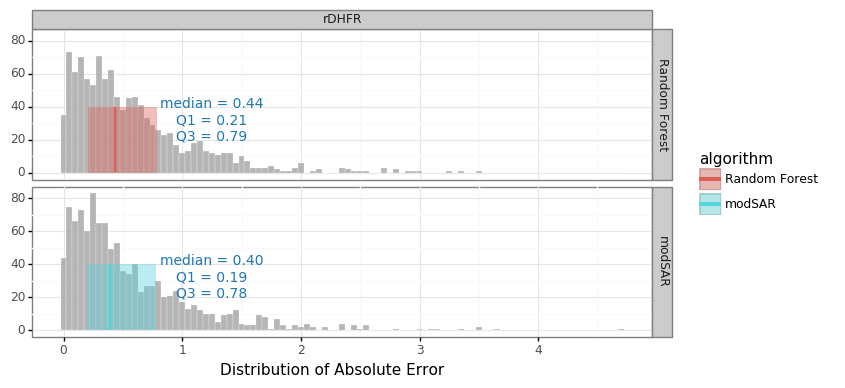

<ggplot: (8778761901923)>

In [222]:
plot_df = pd.concat([external_predictions, rf_external_predictions]).query('dataset == "rDHFR"')
plot2_df = pd.concat([external_abs_stats, rf_external_abs_stats]).reset_index().query('dataset == "rDHFR"')

g = (
  ggplot(plot_df) + 
    geom_histogram(aes(x="absolute_error"), alpha=0.9, color='white', fill='#ADADAD', 
                   binwidth = 0.05, size=0.1) + 
    geom_rect(data=plot2_df, mapping=aes(fill='algorithm', xmin='25%', xmax='75%', ymin=0, ymax=40), 
              alpha=0.4) + 
    geom_segment(data=plot2_df, mapping=aes(y=40, color='algorithm', yend='50%', x='50%', xend='50%'),  size=1) +
    geom_text(data=plot2_df, mapping=aes(label='label'), 
              color='#1f77b4', x=1.25, y=40*0.8, size=10) + 
    theme_bw() + xlab("Distribution of Absolute Error") + ylab("") +
    facet_grid("algorithm ~ dataset") + 
    theme(figure_size=(8, 4))
)
g

In [175]:
rf_external_abs_stats = rf_external_predictions.groupby(['dataset']).apply(get_absolute_error_stats)
rf_external_abs_stats

,label
dataset,
CHRM3,median = 0.53\nQ1 = 0.23\nQ3 = 0.94
NYPR1,median = 0.35\nQ1 = 0.14\nQ3 = 0.69
NYPR2,median = 0.39\nQ1 = 0.19\nQ3 = 0.67
hDHFR,median = 0.50\nQ1 = 0.23\nQ3 = 0.97
rDHFR,median = 0.44\nQ1 = 0.21\nQ3 = 0.79
